In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import gzip, pickle, matplotlib.pyplot as plt

In [7]:
data_path = Path('data/mnist.pkl.gz')
with gzip.open(data_path, 'r') as f:
    ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding='latin') 
x_train, y_train, x_test, y_test = map(torch.tensor, (x_train, y_train, x_test, y_test))
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

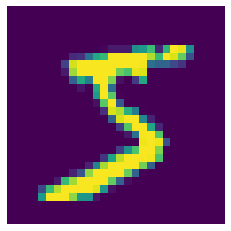

In [11]:
img = x_train[0]
img = img.view(28, 28)
plt.imshow(img);
plt.axis('off');

```python
# simple 2 layer nn

```

In [19]:
class Model(nn.Module):
    def __init__(self, n_in, n_h, n_o):
        super().__init__()
        self.layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_o)]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [119]:
n_in = x_train.shape[1]
n_h = 50
n_o = 10

model = Model(n_in, n_h, n_o)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

```python
# cross entropy loss

```

In [120]:
def log_softmax(x):
    return (x.exp()/x.exp().sum(-1, keepdim=True)).log()

In [121]:
log_softmax(pred)

tensor([[-2.3917, -2.3172, -2.1445,  ..., -2.3604, -2.4435, -2.3298],
        [-2.3426, -2.2119, -2.2799,  ..., -2.3664, -2.4151, -2.2220],
        [-2.3725, -2.2966, -2.2658,  ..., -2.2858, -2.3270, -2.3698],
        ...,
        [-2.4004, -2.3082, -2.1309,  ..., -2.3633, -2.4319, -2.2571],
        [-2.4322, -2.3229, -2.1224,  ..., -2.3613, -2.4487, -2.2554],
        [-2.3660, -2.2850, -2.0563,  ..., -2.3602, -2.5124, -2.3140]],
       grad_fn=<LogBackward0>)

```python
# log product to sum trick

```

In [122]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [123]:
log_softmax(pred)

tensor([[-2.3917, -2.3172, -2.1445,  ..., -2.3604, -2.4435, -2.3298],
        [-2.3426, -2.2119, -2.2799,  ..., -2.3664, -2.4151, -2.2220],
        [-2.3725, -2.2966, -2.2658,  ..., -2.2858, -2.3270, -2.3698],
        ...,
        [-2.4004, -2.3082, -2.1309,  ..., -2.3633, -2.4319, -2.2571],
        [-2.4322, -2.3229, -2.1224,  ..., -2.3613, -2.4487, -2.2554],
        [-2.3660, -2.2850, -2.0563,  ..., -2.3602, -2.5124, -2.3140]],
       grad_fn=<SubBackward0>)

```python
# log sum exp trick
* normalize with the maximum value, so avoid exploding big activations.

```

In [124]:
def logsumexp(x):
    m = x.max(-1)[-1]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [125]:
def log_softmax(x):
    return x - logsumexp(x)[:,None]

In [126]:
log_softmax(pred)

tensor([[-2.3917, -2.3172, -2.1445,  ..., -2.3604, -2.4435, -2.3298],
        [-2.3426, -2.2119, -2.2799,  ..., -2.3664, -2.4151, -2.2220],
        [-2.3725, -2.2966, -2.2658,  ..., -2.2858, -2.3270, -2.3698],
        ...,
        [-2.4004, -2.3082, -2.1309,  ..., -2.3633, -2.4319, -2.2571],
        [-2.4322, -2.3229, -2.1224,  ..., -2.3613, -2.4487, -2.2554],
        [-2.3660, -2.2850, -2.0563,  ..., -2.3602, -2.5124, -2.3140]],
       grad_fn=<SubBackward0>)

```python
# pytorch logsumexp function

```

In [127]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [128]:
log_softmax(pred)

tensor([[-2.3917, -2.3172, -2.1445,  ..., -2.3604, -2.4435, -2.3298],
        [-2.3426, -2.2119, -2.2799,  ..., -2.3664, -2.4151, -2.2220],
        [-2.3725, -2.2966, -2.2658,  ..., -2.2858, -2.3270, -2.3698],
        ...,
        [-2.4004, -2.3082, -2.1309,  ..., -2.3633, -2.4319, -2.2571],
        [-2.4322, -2.3229, -2.1224,  ..., -2.3613, -2.4487, -2.2554],
        [-2.3660, -2.2850, -2.0563,  ..., -2.3602, -2.5124, -2.3140]],
       grad_fn=<SubBackward0>)

```python
# negative log likeliehood
* for one hot input vector, it simplifies to the following formula.

```

In [129]:
def nll(inp, targ):
    return - inp[range(targ.shape[0]), targ].mean()

In [130]:
sm_pred = log_softmax(pred)
loss = nll(sm_pred, y_train)
loss

tensor(2.3028, grad_fn=<NegBackward0>)

```python
# compare it with native pytorch implementation of nll.

```

In [131]:
loss_pytorch = F.nll_loss(F.log_softmax(pred, -1), y_train)
loss_pytorch

tensor(2.3028, grad_fn=<NllLossBackward0>)

```python
# nll and softmax combined implementation.

```

In [132]:
loss_pytorch = F.cross_entropy(pred, y_train)
loss_pytorch

tensor(2.3028, grad_fn=<NllLossBackward0>)

```python
# batch training.

```

```python
# accuracy.

```

In [133]:
def accuracy(out, yb):
    return (out.argmax(1)==yb).float().mean()

loss_func = F.cross_entropy

In [134]:
bs = 50
xb = x_train[:bs]
yb = y_train[:bs]
preds = model(xb)
preds[0]

tensor([-0.0843, -0.0098,  0.1629,  0.1187,  0.1040,  0.0934, -0.1870, -0.0530,
        -0.1361, -0.0224], grad_fn=<SelectBackward0>)

In [135]:
loss_func(preds, yb)

tensor(2.2846, grad_fn=<NllLossBackward0>)

In [136]:
accuracy(preds, yb)

tensor(0.1400)

In [137]:
def report(loss, preds, yb):
    print(f"loss: {loss:.2f}, accuracy: {accuracy(preds, yb):.2f}")

In [138]:
report(loss, preds, yb)

loss: 2.30, accuracy: 0.14


In [139]:
n, m = x_train.shape
lr = 0.5
epochs = 3
xb,yb = x_train[:bs], y_train[:bs]
preds = model(xb)
loss = loss_func(preds, yb)
report(loss, preds, yb)

loss: 2.28, accuracy: 0.14


In [140]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

loss: 0.17, accuracy: 0.94
loss: 0.13, accuracy: 0.94
loss: 0.13, accuracy: 0.96


```python

# parameters

```

In [147]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1.boo = 'hey'
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [148]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [149]:
list(m1.parameters())

[Parameter containing:
 tensor([[-0.4626, -0.5572, -0.2930],
         [-0.2142,  0.2954, -0.5759],
         [-0.0873,  0.5067,  0.0329],
         [ 0.1627,  0.2251, -0.2415]], requires_grad=True),
 Parameter containing:
 tensor([-0.4074,  0.0654,  0.3297, -0.2555], requires_grad=True)]

In [167]:
class MLP(nn.Module):
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, n_h)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(n_h, n_out)
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [168]:
model = MLP(n_in, n_h, 10)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [169]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
relu: ReLU()
l2: Linear(in_features=50, out_features=10, bias=True)


In [170]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [175]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            xb,yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [176]:
fit()

loss: 0.02, accuracy: 1.00
loss: 0.05, accuracy: 0.98
loss: 0.03, accuracy: 1.00


```python
# nn.Module behind the scene.

```

In [180]:
class MyModule:
    def __init__(self, n_in, n_h, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, n_h)
        self.l2 = nn.Linear(n_h, n_out)
        self.relu = nn.ReLU()
    
    def __setattr__(self, k, v):
        if not k.startswith('_'):
            self._modules[k] = v
        
        super().__setattr__(k, v)
    
    def __repr__(self):
        return f"{self._modules}"
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()

In [183]:
mdl = MyModule(n_in, n_h, n_o)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True), 'relu': ReLU()}

In [185]:
for p in mdl.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


```python
# registering modules.

```

In [186]:
from functools import reduce

In [187]:
layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_o)]

In [188]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers):
            self.add_module(f"layer_{i}", l)
    
    def forward(self, x):
        return reduce(lambda val, layer: layer(val), self.layers, x)

In [189]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [190]:
model(xb).shape

torch.Size([50, 10])

```python
# nn.ModuleList.

```

In [191]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [192]:
model = SequentialModel(layers)
model(xb).shape

torch.Size([50, 10])

```python
# nn.Sequential.

```

In [193]:
model = nn.Sequential(*layers)

In [194]:
fit()

loss: 0.14, accuracy: 0.96
loss: 0.11, accuracy: 0.96
loss: 0.05, accuracy: 1.00


In [195]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)